In [26]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [27]:
np.random.seed(42)
tf.random.set_seed(42)
IMAGE_SIZE = (224, 224)  # Define the image size
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [28]:
# Create a simplified SqueezeNet-like model
model = Sequential([
    Conv2D(96, (7, 7), activation='relu', strides=(2, 2), input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), activation='relu'),
    Conv2D(384, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Adjust for your specific task
])


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 109, 109, 96)      14208     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 256)       221440    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 384)      

In [15]:
model.compile(
    loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
# Set the paths to the training and validation data
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path, target_size=IMAGE_SIZE, batch_size=10, class_mode='binary')
test_set = test_datagen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, batch_size=10, class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Python(10674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [19]:
model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,  # You can adjust the number of epochs
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/10
522/522 [==============================] - 290s 555ms/step - loss: 0.5317 - accuracy: 0.7836 - val_loss: 0.6223 - val_accuracy: 0.6538
Epoch 2/10
522/522 [==============================] - 314s 602ms/step - loss: 0.4980 - accuracy: 0.8066 - val_loss: 0.6174 - val_accuracy: 0.7019
Epoch 3/10
522/522 [==============================] - 321s 614ms/step - loss: 0.2856 - accuracy: 0.8804 - val_loss: 0.5507 - val_accuracy: 0.7548
Epoch 4/10
522/522 [==============================] - 330s 631ms/step - loss: 0.2139 - accuracy: 0.9068 - val_loss: 0.3045 - val_accuracy: 0.8782
Epoch 5/10
522/522 [==============================] - 345s 662ms/step - loss: 0.1823 - accuracy: 0.9235 - val_loss: 0.4354 - val_accuracy: 0.8285
Epoch 6/10
522/522 [==============================] - 327s 625ms/step - loss: 0.1795 - accuracy: 0.9277 - val_loss: 0.4298 - val_accuracy: 0.8317
Epoch 7/10
522/522 [==============================] - 329s 630ms/step - loss: 0.1647 - accuracy: 0.9337 - val_loss: 0.4699 -

In [20]:
from keras.preprocessing import image

img = image.load_img('chest_xray/test/PNEUMONIA/person1_virus_11.jpeg', target_size=IMAGE_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = x / 255.0  # Normalize the image
classes = model.predict(img_data)
result = int(classes[0][0])
if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")


1/1 [==============================] - 0s 194ms/step
Person is Affected By PNEUMONIA


In [22]:
true_labels = []
predicted_labels = []

for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)
    
    true_labels.extend(labels)  # Labels are already in the correct format (no need to use argmax)
    predicted_labels.extend(predictions)

# Convert true_labels and predicted_labels to numpy arrays
t_labels = np.array(true_labels)
p_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 67ms/step


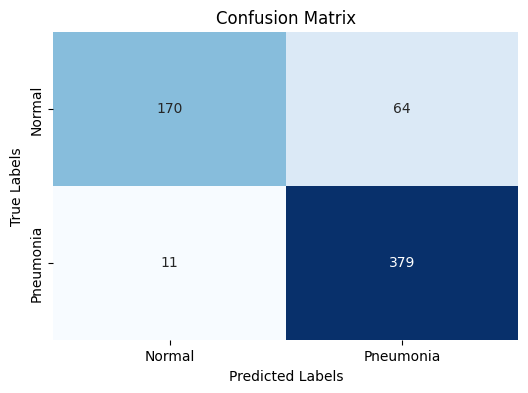

Accuracy: 0.8798076923076923


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Convert true_labels and predicted_labels to binary labels (0 or 1)
true_labels = np.array(true_labels)
predicted_labels = (np.array(predicted_labels) > 0.5).astype(int)  # Threshold at 0.5

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'])
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'])
plt.show()

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1_score = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.8555304740406321
Recall: 0.9717948717948718
F1 Score: 0.9099639855942376
